In [2]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


In [3]:
import os
import glob
import random
import numpy as np
import cv2
import xml.etree.ElementTree as ET

# --- CONFIGURATION ---
# The target path you provided
DATASET_ROOT = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/MonuSeg"

def scan_directory_structure(root_path):
    """
    Walks through the directory to print the tree structure 
    and count file types (e.g., how many .tif, .xml, .png).
    """
    print(f"\n=== 📂 SCANNING: {root_path} ===")
    
    if not os.path.exists(root_path):
        print(f"[ERROR] Path not found: {root_path}")
        return None

    file_registry = {} # To store paths by extension

    for root, dirs, files in os.walk(root_path):
        # Calculate depth to indent output
        level = root.replace(root_path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        sub_folder = os.path.basename(root)
        
        # Print folder name (limit output to avoid spamming console)
        if level < 2:
            print(f"{indent}[DIR] {sub_folder}/ (Contains {len(files)} files)")
        
        # Tally extensions
        for f in files:
            ext = os.path.splitext(f)[1].lower()
            if ext not in file_registry:
                file_registry[ext] = []
            file_registry[ext].append(os.path.join(root, f))

    print("\n=== 📊 FILE TYPE SUMMARY ===")
    for ext, paths in file_registry.items():
        print(f"  {ext}: {len(paths)} files")
        
    return file_registry

def analyze_monuseg_sample(file_registry):
    """
    Intelligently picks a sample image and tries to find its label 
    (handling both XML and Mask formats).
    """
    print(f"\n=== 🕵️ INVESTIGATING DATA FORMAT ===")
    
    # 1. Find Images (MoNuSeg is usually .tif or .png)
    img_candidates = file_registry.get('.tif', []) + file_registry.get('.png', []) + file_registry.get('.jpg', [])
    
    if not img_candidates:
        print("[!] No standard images (.tif, .png, .jpg) found.")
        return

    # Pick a random image
    sample_img_path = random.choice(img_candidates)
    base_name = os.path.basename(sample_img_path)
    name_no_ext = os.path.splitext(base_name)[0]
    
    print(f"1. Selected Image: {base_name}")
    print(f"   Path: {sample_img_path}")
    
    # Load Image
    img = cv2.imread(sample_img_path)
    if img is not None:
        print(f"   Shape: {img.shape}, Dtype: {img.dtype}, Range: [{img.min()}, {img.max()}]")
    else:
        print("   [Error] Could not read image file.")

    # 2. Hunt for the Label
    # Strategy A: Look for XML (Original MoNuSeg format)
    xml_candidates = file_registry.get('.xml', [])
    matching_xml = [x for x in xml_candidates if name_no_ext in os.path.basename(x)]
    
    # Strategy B: Look for Binary Mask (Processed format)
    # Often stored in a separate folder, or with a suffix like '_mask', '_binary'
    mask_candidates = file_registry.get('.png', []) + file_registry.get('.bmp', [])
    matching_mask = [x for x in mask_candidates if name_no_ext in os.path.basename(x) and x != sample_img_path]

    if matching_xml:
        print(f"\n2. [MATCH FOUND] XML Annotation detected: {os.path.basename(matching_xml[0])}")
        try:
            tree = ET.parse(matching_xml[0])
            root = tree.getroot()
            # MoNuSeg XMLs usually have <Region> tags for nuclei
            regions = root.findall(".//Region")
            print(f"   -> Parsed XML successfully.")
            print(f"   -> Found {len(regions)} annotated regions (nuclei) in this file.")
            print("   -> Format: Standard MoNuSeg XML (Vector coordinates).")
        except Exception as e:
            print(f"   -> [Error parsing XML]: {e}")

    elif matching_mask:
        print(f"\n2. [MATCH FOUND] Binary/Instance Mask detected: {os.path.basename(matching_mask[0])}")
        mask = cv2.imread(matching_mask[0], cv2.IMREAD_UNCHANGED)
        print(f"   -> Mask Shape: {mask.shape}")
        unique_vals = np.unique(mask)
        print(f"   -> Unique Values: {unique_vals}")
        if len(unique_vals) > 2:
            print("   -> Type: Instance Segmentation (Different ID per nucleus)")
        else:
            print("   -> Type: Binary Segmentation (0=Bg, 1=Nuclei)")
            
    else:
        print("\n2. [WARNING] No matching label (XML or Mask) found for this image.")
        print("   (This might be a test image, or the naming convention implies a specific folder structure not detected by name matching.)")

def main():
    registry = scan_directory_structure(DATASET_ROOT)
    if registry:
        analyze_monuseg_sample(registry)

if __name__ == "__main__":
    main()


=== 📂 SCANNING: /rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/MonuSeg ===
[DIR] MonuSeg/ (Contains 1 files)
    [DIR] kmms_test/ (Contains 1 files)
    [DIR] kmms_training/ (Contains 1 files)

=== 📊 FILE TYPE SUMMARY ===
  : 5 files
  .png: 132 files
  .tif: 32 files

=== 🕵️ INVESTIGATING DATA FORMAT ===
1. Selected Image: 07_3  .png
   Path: /rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/MonuSeg/kmms_test/kmms_test/masks/07_3  .png
   Shape: (256, 256, 3), Dtype: uint8, Range: [0, 255]

2. [WARNING] No matching label (XML or Mask) found for this image.
   (This might be a test image, or the naming convention implies a specific folder structure not detected by name matching.)


In [1]:
import os
import glob
import numpy as np
import zarr
import pandas as pd
import cv2
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import numcodecs
import xml.etree.ElementTree as ET
import random

# --- CONFIGURATION ---
BASE_PATH = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/MoNuSeg")
OUTPUT_BASE = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/monuseg/zarr_data")

PATCH_SIZE = 512
NUM_WORKERS = 16
VAL_SPLIT = 0.10  # 10% of training data for validation
SEED = 42

cv2.setNumThreads(0)
random.seed(SEED)
np.random.seed(SEED)

# ---------------------------------------------------------------------
# 1. XML to Instance Mask Conversion
# ---------------------------------------------------------------------
def xml_to_instance_mask(xml_path, img_shape):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
    except Exception as e:
        print(f"⚠️  Error parsing XML {xml_path}: {e}")
        return np.zeros(img_shape, dtype=np.int32)
    
    # Create empty instance mask
    instance_mask = np.zeros(img_shape, dtype=np.int32)
    
    instance_id = 1
    # Each Region = one nucleus instance
    for region in root.iter('Region'):
        vertices = []
        
        # Extract all vertices for this nucleus boundary
        for vertex in region.iter('Vertex'):
            x = float(vertex.get('X'))
            y = float(vertex.get('Y'))
            vertices.append([x, y])
        
        if len(vertices) > 2:  # Need at least 3 points for a polygon
            # Draw filled polygon with unique instance ID
            vertices_array = np.array(vertices, dtype=np.int32)
            cv2.fillPoly(instance_mask, [vertices_array], color=instance_id)
            instance_id += 1
    
    return instance_mask

# ---------------------------------------------------------------------
# 2. Padding Logic
# ---------------------------------------------------------------------
def pad_to_512_multiple(img):
    """Pad image/mask to be evenly divisible by 512"""
    h, w = img.shape[:2]
    target_h = max(int(np.ceil(h / PATCH_SIZE) * PATCH_SIZE), PATCH_SIZE)
    target_w = max(int(np.ceil(w / PATCH_SIZE) * PATCH_SIZE), PATCH_SIZE)
    
    pad_h, pad_w = target_h - h, target_w - w
    if pad_h == 0 and pad_w == 0:
        return img
    
    # Handle both 2D (mask) and 3D (image) arrays
    if img.ndim == 3:
        padding = ((0, pad_h), (0, pad_w), (0, 0))
    else:
        padding = ((0, pad_h), (0, pad_w))
    
    return np.pad(img, padding, mode='constant', constant_values=0)

# ---------------------------------------------------------------------
# 3. Worker Function - Process Single Slide
# ---------------------------------------------------------------------
def process_slide(args):
    """
    Process one image+xml pair and save to the specific output directory.
    """
    img_path, xml_path, clean_name, out_dir = args
    
    try:
        # --- A. Load Image ---
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"⚠️  Cannot read image: {img_path}")
            return 0, 0
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h_img, w_img = img.shape[:2]
        
        # --- B. Parse XML to Instance Mask ---
        if xml_path and xml_path.exists():
            mask = xml_to_instance_mask(xml_path, (h_img, w_img))
        else:
            print(f"⚠️  No XML found for {clean_name}, creating empty mask")
            mask = np.zeros((h_img, w_img), dtype=np.int32)
        
        # --- C. Pad to 512 Multiples ---
        img_padded = pad_to_512_multiple(img)
        mask_padded = pad_to_512_multiple(mask)
        h_pad, w_pad = img_padded.shape[:2]
        
        # --- D. Extract 512x512 Patches ---
        img_stack, mask_stack, metadata_list = [], [], []
        
        for y in range(0, h_pad, PATCH_SIZE):
            for x in range(0, w_pad, PATCH_SIZE):
                crop_img = img_padded[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
                crop_mask = mask_padded[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
                
                # Ensure full 512x512 patch
                if crop_img.shape[0] == PATCH_SIZE and crop_img.shape[1] == PATCH_SIZE:
                    img_stack.append(crop_img)
                    mask_stack.append(crop_mask)
                    metadata_list.append({
                        'original_file': clean_name,
                        'x': x,
                        'y': y,
                        'original_height': h_img,
                        'original_width': w_img
                    })
        
        if not img_stack:
            return 0, 0
        
        # --- E. Save to Zarr ---
        slide_out_path = out_dir / clean_name
        # Clean previous run if exists
        if slide_out_path.exists():
            import shutil
            shutil.rmtree(slide_out_path)
        os.makedirs(slide_out_path, exist_ok=True)
        
        compressor = numcodecs.Blosc(cname='zstd', clevel=3)
        
        final_imgs = np.stack(img_stack, axis=0)
        final_masks = np.stack(mask_stack, axis=0)
        
        # Save images
        z_img = zarr.open_array(
            str(slide_out_path / 'images.zarr'),
            mode='w',
            shape=final_imgs.shape,
            chunks=(1, 512, 512, 3),
            dtype='uint8',
            compressor=compressor
        )
        z_img[:] = final_imgs
        
        # Save instance masks
        z_mask = zarr.open_array(
            str(slide_out_path / 'nuclei_masks.zarr'),
            mode='w',
            shape=final_masks.shape,
            chunks=(1, 512, 512),
            dtype='int32',
            compressor=compressor
        )
        z_mask[:] = final_masks
        
        # Save metadata
        pd.DataFrame(metadata_list).to_csv(
            slide_out_path / 'metadata.csv',
            index=False
        )
        
        return len(img_stack), 0
    
    except Exception as e:
        print(f"❌ Error processing {clean_name}: {e}")
        return 0, 0

# ---------------------------------------------------------------------
# 4. Helpers for File Collection
# ---------------------------------------------------------------------
def get_image_xml_pairs(folder_path, is_train_structure=False):
    """
    Finds pairs of (.tif, .xml).
    Train folder usually has 'Tissue Images' and 'Annotations' subdirs.
    Test folder is usually flat.
    """
    pairs = []
    
    if is_train_structure:
        img_dir = folder_path / "Tissue Images"
        xml_dir = folder_path / "Annotations"
    else:
        img_dir = folder_path
        xml_dir = folder_path
        
    if not img_dir.exists():
        return pairs

    # MoNuSeg images are usually .tif or .png
    images = sorted(list(img_dir.glob("*.tif")) + list(img_dir.glob("*.png")))
    
    for img_path in images:
        clean_name = img_path.stem
        # Try finding XML (sometimes names match exactly, sometimes slightly different, assume exact match for now)
        xml_path = xml_dir / f"{clean_name}.xml"
        
        if xml_path.exists():
            pairs.append((img_path, xml_path, clean_name))
        else:
            print(f"⚠️  Warning: Missing XML for {clean_name} in {folder_path.name}")
            # We skip images without ground truth for training purposes
            
    return pairs

# ---------------------------------------------------------------------
# 5. Main Processing Pipeline
# ---------------------------------------------------------------------
def main():
    print("=" * 70)
    print("🔬 MoNuSeg Split: Train(90%) / Val(10%) | Test(Keep As Is)")
    print("=" * 70)
    
    all_tasks = []

    # --- 1. Process TEST Set (Keep Intact) ---
    test_path = BASE_PATH / "test"
    if test_path.exists():
        test_pairs = get_image_xml_pairs(test_path, is_train_structure=False)
        print(f"\n📂 Found {len(test_pairs)} Test slides.")
        
        out_test = OUTPUT_BASE / "monuseg_test"
        for p in test_pairs:
            # Task format: (img, xml, name, out_dir)
            all_tasks.append((p[0], p[1], p[2], out_test))
    else:
        print("⚠️  Test folder not found.")

    # --- 2. Process TRAIN Set (Split into Train/Val) ---
    train_path = BASE_PATH / "train"
    if train_path.exists():
        # Train data often has subdirectories
        train_pairs = get_image_xml_pairs(train_path, is_train_structure=True)
        
        if not train_pairs:
            # Fallback: check if it's flat structure
            train_pairs = get_image_xml_pairs(train_path, is_train_structure=False)
            
        print(f"\n📂 Found {len(train_pairs)} Source Train slides.")
        
        # SHUFFLE AND SPLIT
        random.shuffle(train_pairs)
        
        num_val = int(len(train_pairs) * VAL_SPLIT)
        # Ensure at least 1 val slide if dataset is small
        if num_val == 0 and len(train_pairs) > 1:
            num_val = 1
            
        val_subset = train_pairs[:num_val]
        train_subset = train_pairs[num_val:]
        
        print(f"   📊 Split Result:")
        print(f"      Training:   {len(train_subset)} slides")
        print(f"      Validation: {len(val_subset)} slides")
        
        out_train = OUTPUT_BASE / "monuseg_train"
        out_val = OUTPUT_BASE / "monuseg_val"
        
        for p in train_subset:
            all_tasks.append((p[0], p[1], p[2], out_train))
            
        for p in val_subset:
            all_tasks.append((p[0], p[1], p[2], out_val))
            
    else:
        print("⚠️  Train folder not found.")

    if not all_tasks:
        print("❌ No tasks created.")
        return

    # --- 3. Execute ---
    print(f"\n🚀 Processing {len(all_tasks)} total slides...")
    
    OUTPUT_BASE.mkdir(parents=True, exist_ok=True)
    
    with ProcessPoolExecutor(max_workers=NUM_WORKERS) as executor:
        results = list(tqdm(
            executor.map(process_slide, all_tasks),
            total=len(all_tasks),
            desc="Converting to Zarr"
        ))
    
    print("\n✅ DONE")

if __name__ == "__main__":
    main()

🔬 MoNuSeg Split: Train(90%) / Val(10%) | Test(Keep As Is)

📂 Found 14 Test slides.

📂 Found 37 Source Train slides.
   📊 Split Result:
      Training:   34 slides
      Validation: 3 slides

🚀 Processing 51 total slides...


Converting to Zarr: 100%|██████████| 51/51 [00:03<00:00, 14.06it/s]


✅ DONE



📊 DATASET SUMMARY

MONUSEG_TRAIN:
   Slides: 37
   Total patches: 148
   Total nuclei: 25173
   Avg nuclei/patch: 170.1

MONUSEG_TEST:
   Slides: 14
   Total patches: 56
   Total nuclei: 7042
   Avg nuclei/patch: 125.8



👀 INSPECTING ZARR DATA AT: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/monuseg/zarr_data

──────────────────────────────────────────────────────────────────────
📂 CATEGORY: MONUSEG_TRAIN
   Total slides: 37
   Showing: 3 random samples
──────────────────────────────────────────────────────────────────────

   [1/3] TCGA-G9-6363-01Z-00-DX1
        Patches: 4
        Selected patch: #3
        Nuclei in patch: 95
        Size range: 16-1419 pixels (avg: 650)
        Position: x=512, y=512


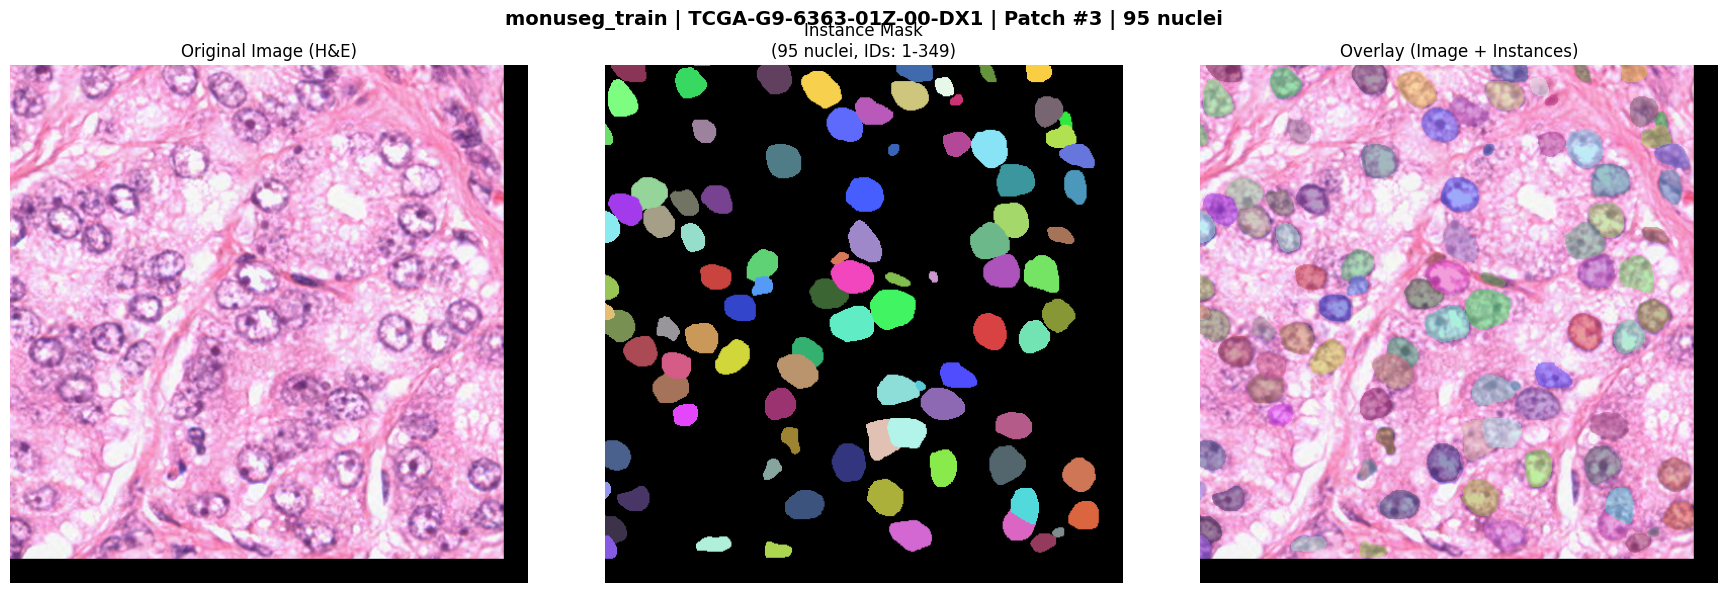

        ✅ Visualization complete

   [2/3] TCGA-E2-A1B5-01Z-00-DX1
        Patches: 4
        Selected patch: #1
        Nuclei in patch: 96
        Size range: 6-1092 pixels (avg: 360)
        Position: x=512, y=0


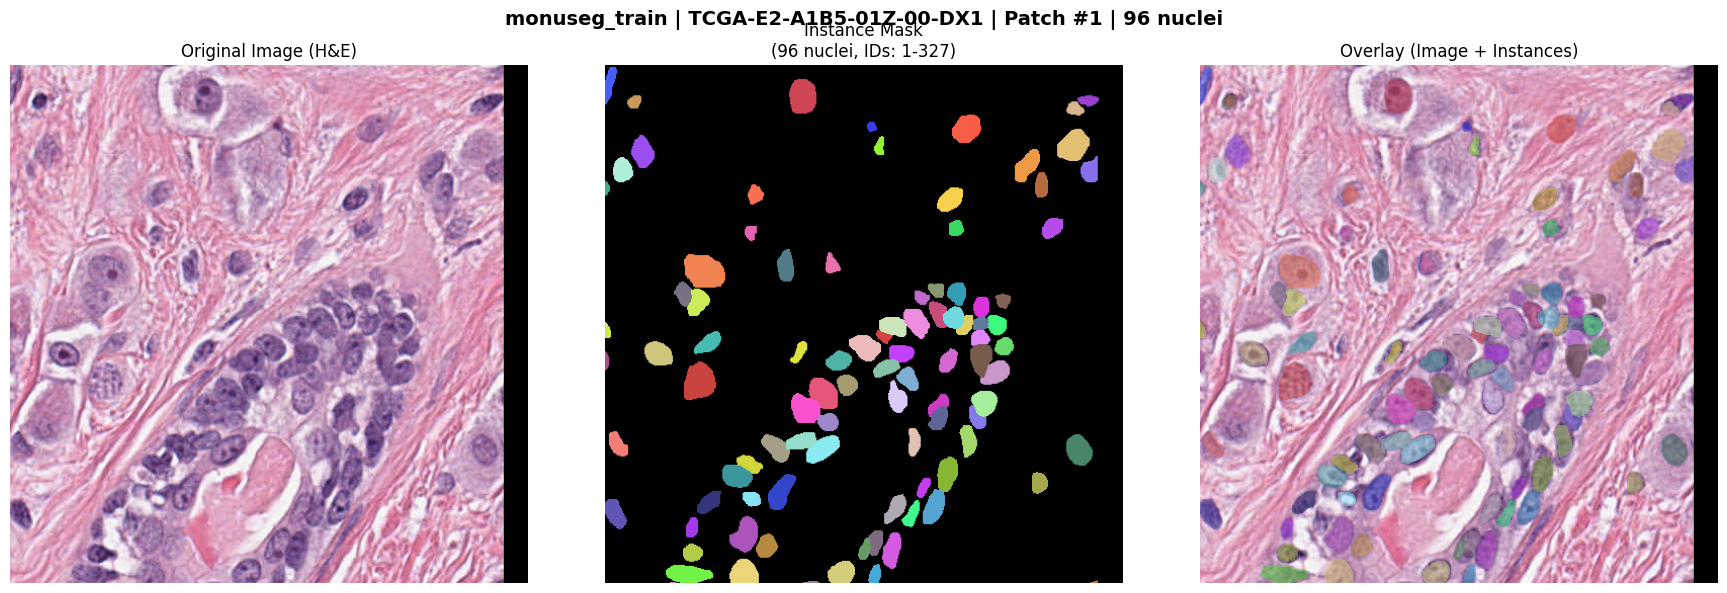

        ✅ Visualization complete

   [3/3] TCGA-B0-5698-01Z-00-DX1
        Patches: 4
        Selected patch: #3
        Nuclei in patch: 93
        Size range: 34-615 pixels (avg: 317)
        Position: x=512, y=512


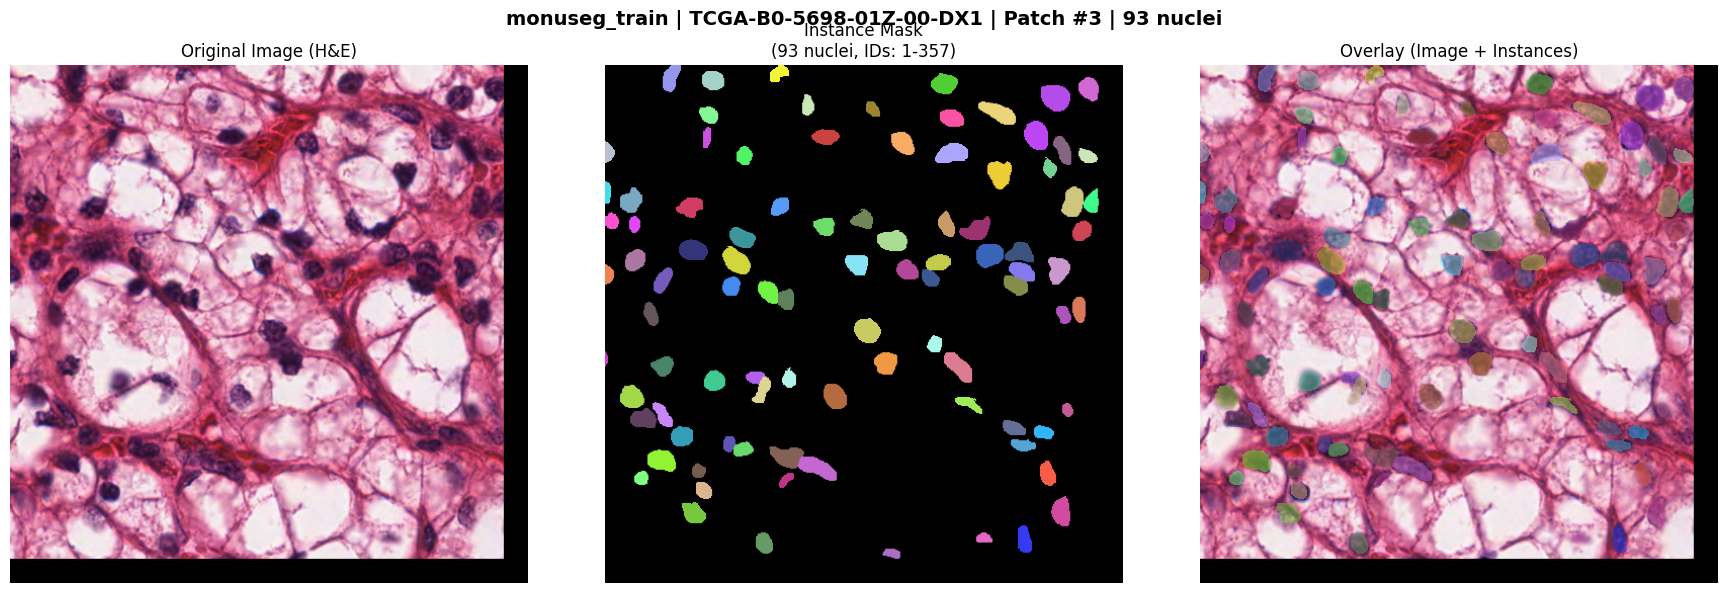

        ✅ Visualization complete

──────────────────────────────────────────────────────────────────────
📂 CATEGORY: MONUSEG_TEST
   Total slides: 14
   Showing: 3 random samples
──────────────────────────────────────────────────────────────────────

   [1/3] TCGA-GL-6846-01A-01-BS1
        Patches: 4
        Selected patch: #1
        Nuclei in patch: 108
        Size range: 37-1210 pixels (avg: 531)
        Position: x=512, y=0


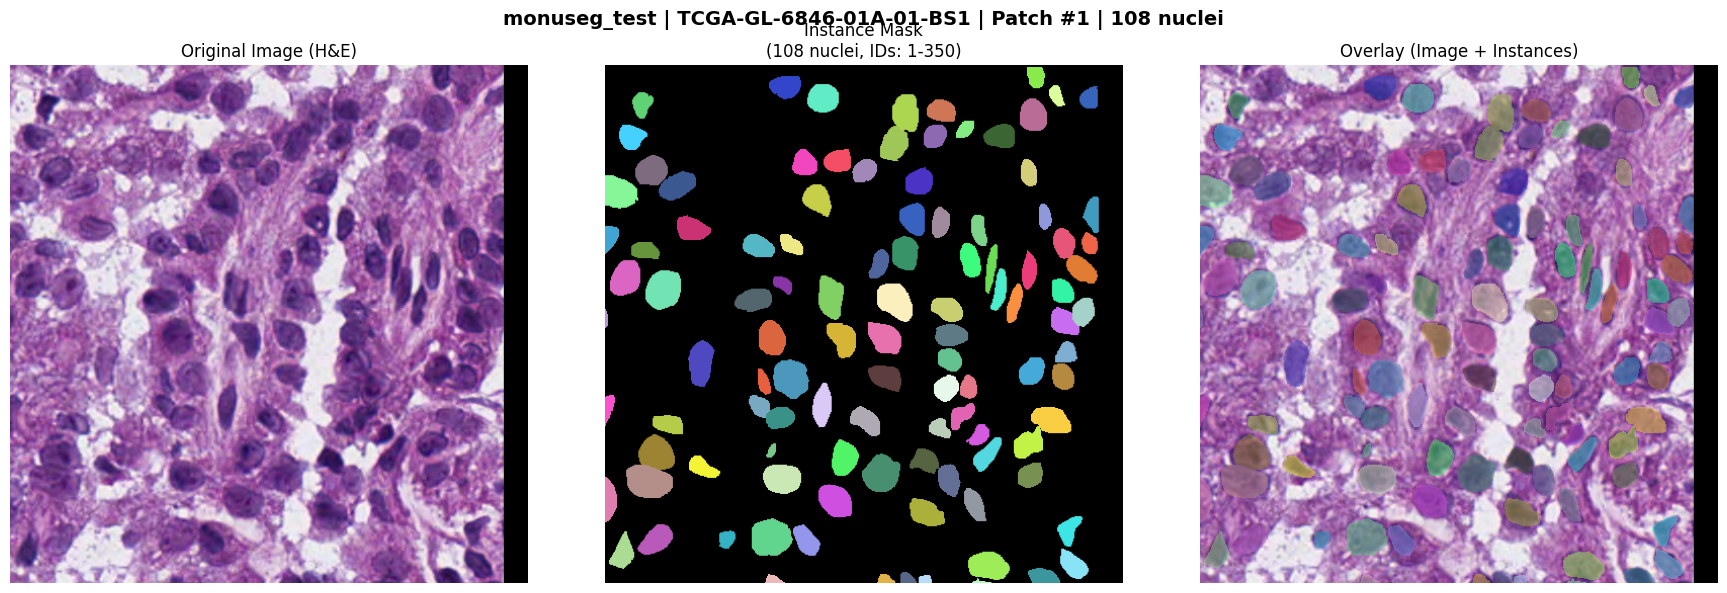

        ✅ Visualization complete

   [2/3] TCGA-IZ-8196-01A-01-BS1
        Patches: 4
        Selected patch: #0
        Nuclei in patch: 139
        Size range: 84-1058 pixels (avg: 482)
        Position: x=0, y=0


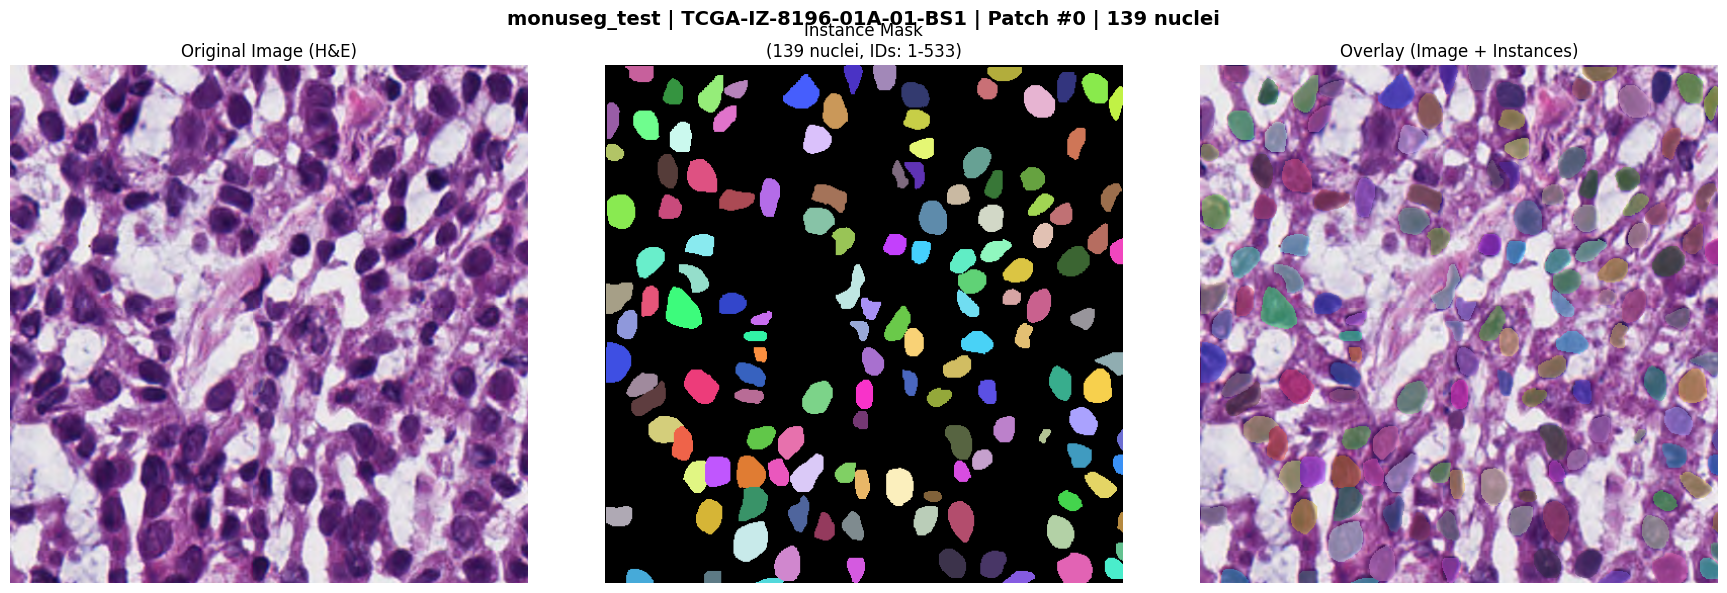

        ✅ Visualization complete

   [3/3] TCGA-HC-7209-01A-01-TS1
        Patches: 4
        Selected patch: #2
        Nuclei in patch: 113
        Size range: 1-1195 pixels (avg: 436)
        Position: x=0, y=512


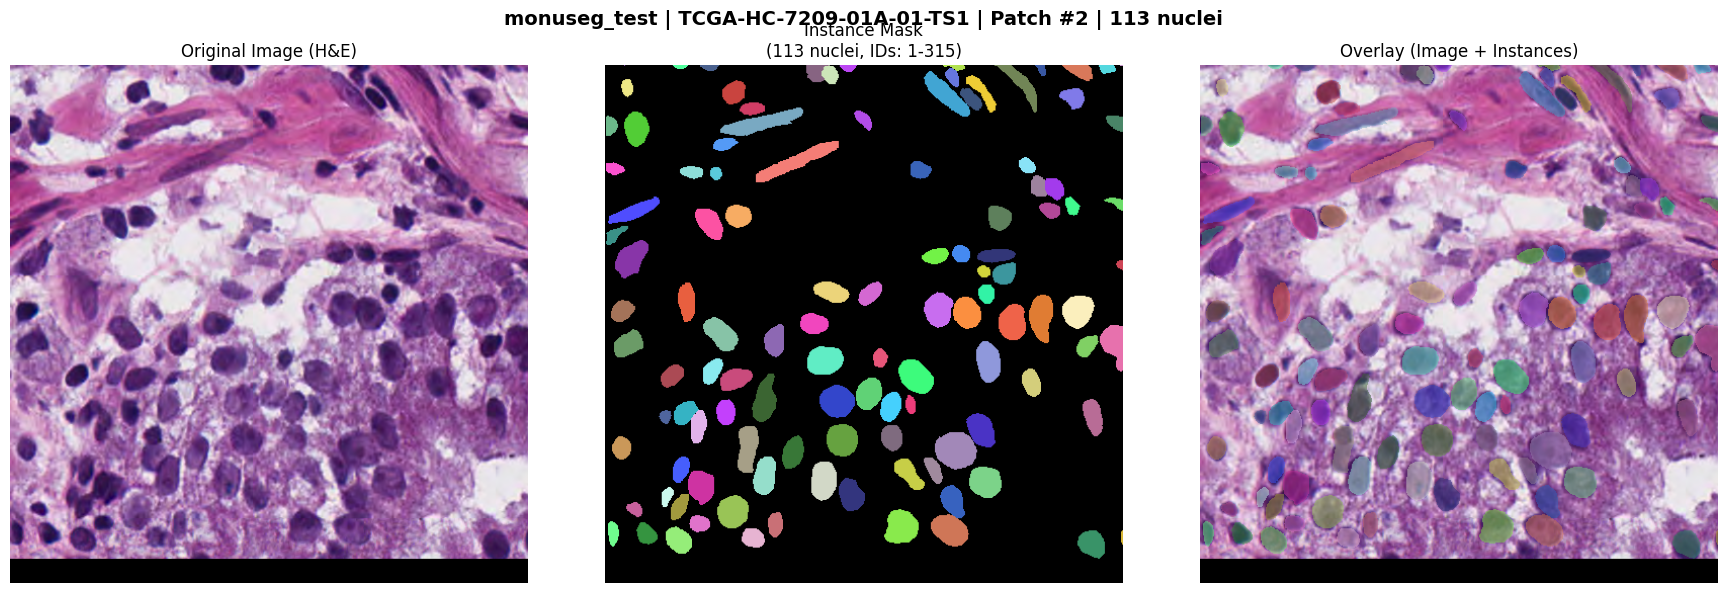

        ✅ Visualization complete

✅ Dataset inspection complete!


In [40]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from pathlib import Path

# --- CONFIGURATION ---
ZARR_DATA_ROOT = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/monuseg/zarr_data")

def colorize_instances(mask):
    """
    Creates a random RGB color map for an instance mask.
    Background (0) is always Black.
    Each unique instance ID gets a unique color.
    """
    max_id = int(mask.max())
    if max_id == 0:
        return np.zeros((*mask.shape, 3), dtype=np.uint8)
    
    # Create a random color for every possible ID
    # Using a fixed seed so colors are consistent for the same mask, 
    # but random across IDs.
    np.random.seed(42) 
    colors = np.random.randint(50, 255, size=(max_id + 1, 3), dtype=np.uint8)
    
    # Force background to black
    colors[0] = [0, 0, 0]
    
    # Map the IDs to colors
    colored_mask = colors[mask]
    return colored_mask

def get_instance_stats(mask):
    """Get statistics about instances in the mask"""
    unique_ids = np.unique(mask)
    num_instances = len(unique_ids[unique_ids > 0])  # Exclude background
    
    instance_sizes = []
    for inst_id in unique_ids:
        if inst_id > 0:
            size = np.sum(mask == inst_id)
            instance_sizes.append(size)
    
    return {
        'num_instances': num_instances,
        'min_size': min(instance_sizes) if instance_sizes else 0,
        'max_size': max(instance_sizes) if instance_sizes else 0,
        'avg_size': np.mean(instance_sizes) if instance_sizes else 0
    }

def visualize_dataset(root_path, samples_per_category=5):
    """
    Visualize random samples from the MoNuSeg zarr dataset.
    Now works with monuseg_train and monuseg_test directories.
    """
    categories = ["monuseg_train", "monuseg_test"]
    
    print("=" * 70)
    print(f"👀 INSPECTING ZARR DATA AT: {root_path}")
    print("=" * 70)
    
    for cat in categories:
        cat_path = root_path / cat
        if not cat_path.exists():
            print(f"\n⚠️  Skipping {cat} (folder not found)")
            continue
        
        # Get all sample directories
        samples = [d for d in cat_path.iterdir() if d.is_dir() and not d.name.startswith('.')]
        
        if not samples:
            print(f"\n⚠️  No samples found in {cat}")
            continue
        
        # Randomly select samples
        chosen = random.sample(samples, min(len(samples), samples_per_category))
        
        print(f"\n{'─' * 70}")
        print(f"📂 CATEGORY: {cat.upper()}")
        print(f"   Total slides: {len(samples)}")
        print(f"   Showing: {len(chosen)} random samples")
        print(f"{'─' * 70}")
        
        for sample_idx, sample_path in enumerate(chosen, 1):
            sample_id = sample_path.name
            
            try:
                # Open zarr arrays
                z_img = zarr.open(str(sample_path / "images.zarr"), mode='r')
                z_msk = zarr.open(str(sample_path / "nuclei_masks.zarr"), mode='r')
                
                # Get metadata if available
                metadata_path = sample_path / "metadata.csv"
                if metadata_path.exists():
                    import pandas as pd
                    metadata = pd.read_csv(metadata_path)
                else:
                    metadata = None
                
                # Pick a random patch from this sample
                num_patches = z_img.shape[0]
                idx = random.randint(0, num_patches - 1)
                
                img_patch = z_img[idx]
                mask_patch = z_msk[idx]
                
                # Get instance statistics
                stats = get_instance_stats(mask_patch)
                
                # Print info
                print(f"\n   [{sample_idx}/{len(chosen)}] {sample_id}")
                print(f"        Patches: {num_patches}")
                print(f"        Selected patch: #{idx}")
                print(f"        Nuclei in patch: {stats['num_instances']}")
                print(f"        Size range: {stats['min_size']}-{stats['max_size']} pixels (avg: {stats['avg_size']:.0f})")
                
                if metadata is not None:
                    patch_meta = metadata.iloc[idx]
                    print(f"        Position: x={patch_meta['x']}, y={patch_meta['y']}")
                
                # --- PLOTTING ---
                fig, ax = plt.subplots(1, 3, figsize=(18, 6))
                fig.suptitle(
                    f"{cat} | {sample_id} | Patch #{idx} | {stats['num_instances']} nuclei",
                    fontsize=14,
                    fontweight='bold'
                )
                
                # 1. Original Image
                ax[0].imshow(img_patch)
                ax[0].set_title("Original Image (H&E)", fontsize=12)
                ax[0].axis('off')
                
                # 2. Instance Mask (Random Colors)
                colored_mask = colorize_instances(mask_patch)
                ax[1].imshow(colored_mask)
                ax[1].set_title(
                    f"Instance Mask\n({stats['num_instances']} nuclei, IDs: 1-{mask_patch.max()})",
                    fontsize=12
                )
                ax[1].axis('off')
                
                # 3. Overlay
                # Create overlay with transparency
                overlay_img = img_patch.copy()
                
                # Create alpha channel based on mask
                alpha = np.where(mask_patch > 0, 0.5, 0.0)  # 50% transparency for nuclei
                
                # Blend the colored mask with the original image
                for c in range(3):
                    overlay_img[:, :, c] = (
                        img_patch[:, :, c] * (1 - alpha) + 
                        colored_mask[:, :, c] * alpha
                    ).astype(np.uint8)
                
                ax[2].imshow(overlay_img)
                ax[2].set_title("Overlay (Image + Instances)", fontsize=12)
                ax[2].axis('off')
                
                plt.tight_layout()
                plt.show()
                print(f"        ✅ Visualization complete")
                
            except Exception as e:
                print(f"\n        ❌ Error reading {sample_id}: {e}")
                import traceback
                traceback.print_exc()
    
    print("\n" + "=" * 70)
    print("✅ Dataset inspection complete!")
    print("=" * 70)

def print_dataset_summary(root_path):
    """Print summary statistics for the entire dataset"""
    categories = ["monuseg_train", "monuseg_test"]
    
    print("\n" + "=" * 70)
    print("📊 DATASET SUMMARY")
    print("=" * 70)
    
    for cat in categories:
        cat_path = root_path / cat
        if not cat_path.exists():
            continue
        
        samples = [d for d in cat_path.iterdir() if d.is_dir() and not d.name.startswith('.')]
        
        total_patches = 0
        total_nuclei = 0
        
        for sample_path in samples:
            try:
                z_msk = zarr.open(str(sample_path / "nuclei_masks.zarr"), mode='r')
                total_patches += z_msk.shape[0]
                
                # Count nuclei in all patches
                for patch_idx in range(z_msk.shape[0]):
                    mask = z_msk[patch_idx]
                    unique_ids = np.unique(mask)
                    total_nuclei += len(unique_ids[unique_ids > 0])
            except:
                pass
        
        print(f"\n{cat.upper()}:")
        print(f"   Slides: {len(samples)}")
        print(f"   Total patches: {total_patches}")
        print(f"   Total nuclei: {total_nuclei}")
        if total_patches > 0:
            print(f"   Avg nuclei/patch: {total_nuclei/total_patches:.1f}")
    
    print("\n" + "=" * 70)

if __name__ == "__main__":
    if ZARR_DATA_ROOT.exists():
        # First print overall summary
        print_dataset_summary(ZARR_DATA_ROOT)
        
        # Then visualize random samples
        print("\n")
        visualize_dataset(ZARR_DATA_ROOT, samples_per_category=3)
    else:
        print(f"❌ Path not found: {ZARR_DATA_ROOT}")
        print("   Please check your ZARR_DATA_ROOT configuration.")

🔎 LOADING SAMPLES...
MoNuSeg Path: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/monuseg/zarr_data/monuseg_train/TCGA-38-6178-01Z-00-DX1
Xenium Path:  /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/Xenium/zarr_data/ovarian/he


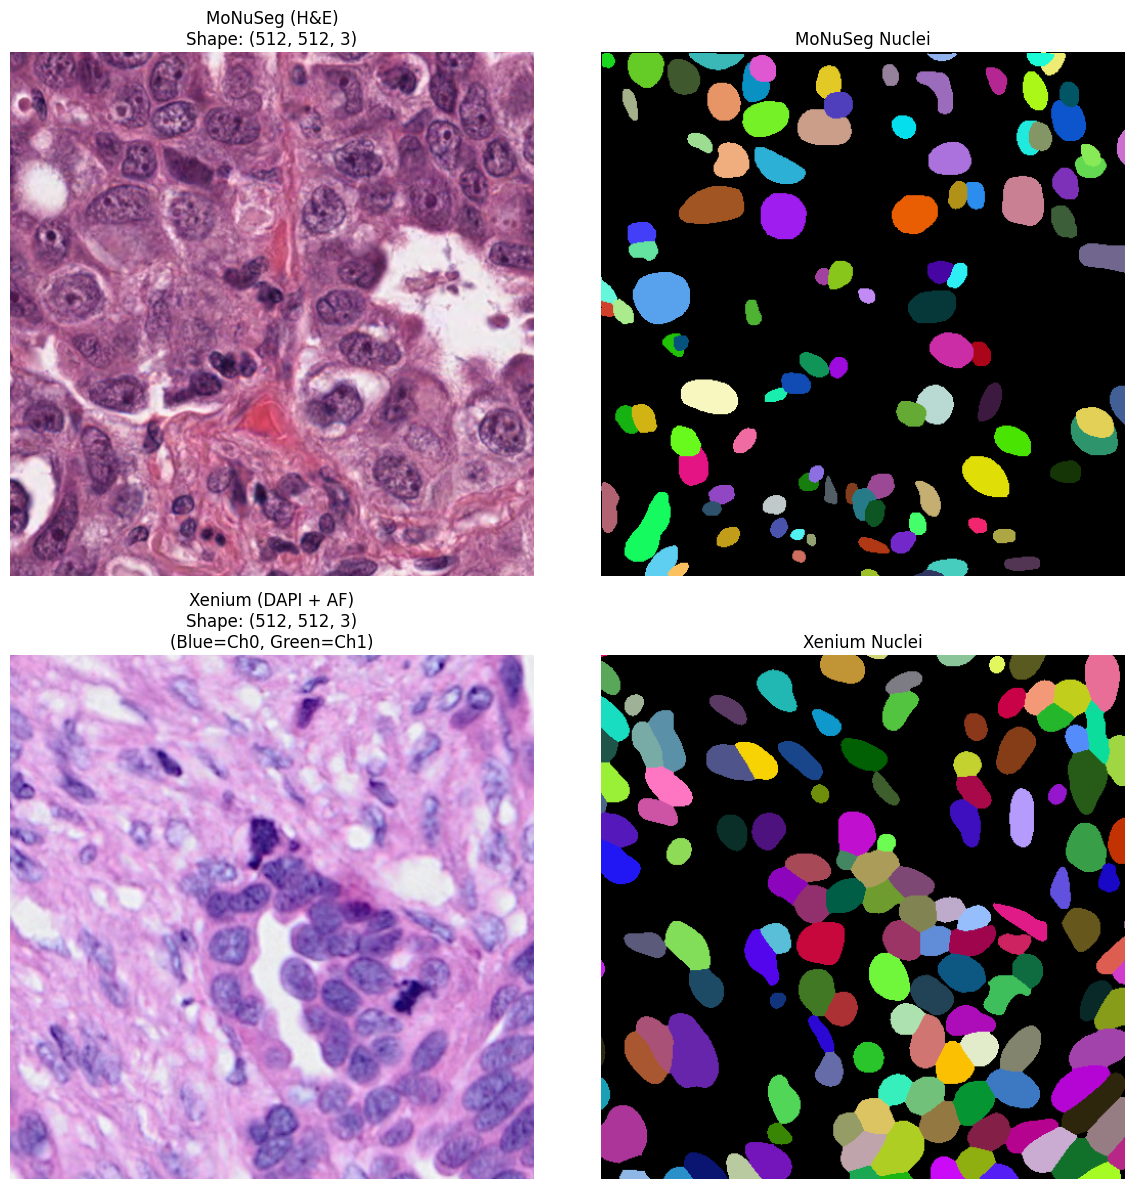

In [39]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# ---------------------------------------------------------------------
# 1. Configuration
# ---------------------------------------------------------------------
monuseg_base_path = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/monuseg/zarr_data"
xenium_base_path = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/Xenium/zarr_data"

# ---------------------------------------------------------------------
# 2. Robust Visualization Helper (Handles 2-Channel & uint16)
# ---------------------------------------------------------------------
def normalize_and_colorize(img):
    """
    Intelligently converts any image shape/dtype into a viewable RGB plot.
    """
    # Case A: Standard RGB (H&E) - uint8
    if img.ndim == 3 and img.shape[2] == 3:
        return img 

    # Case B: 2-Channel (Xenium DAPI + Morph) - uint16
    if img.ndim == 3 and img.shape[2] == 2:
        h, w, _ = img.shape
        pseudo_rgb = np.zeros((h, w, 3), dtype=np.float32)
        
        # Separate channels
        ch0 = img[:, :, 0].astype(float) # Usually DAPI (Nuclei)
        ch1 = img[:, :, 1].astype(float) # Usually Autofluorescence
        
        # Robust Normalization (Scale 0 to 1 based on 99th percentile to ignore outliers)
        ch0 /= (np.percentile(ch0, 99) + 1e-5)
        ch1 /= (np.percentile(ch1, 99) + 1e-5)
        
        # Map to Colors: Ch0 -> Blue, Ch1 -> Green
        pseudo_rgb[:, :, 2] = np.clip(ch0, 0, 1) # Blue channel
        pseudo_rgb[:, :, 1] = np.clip(ch1, 0, 1) # Green channel
        
        return pseudo_rgb

    # Case C: Grayscale - uint16 or uint8
    if img.ndim == 2 or (img.ndim == 3 and img.shape[2] == 1):
        img = img.squeeze()
        img = img.astype(float)
        img /= (np.max(img) + 1e-5)
        return np.stack([img]*3, axis=-1) # Return as Grayscale RGB

    return img

def colorize_instance_map(instance_map):
    """Random colors for instance IDs (0 is black)."""
    max_id = int(instance_map.max())
    if max_id == 0: return np.zeros((*instance_map.shape, 3))
    colors = np.random.rand(max_id + 1, 3)
    colors[0] = [0, 0, 0] 
    return colors[instance_map]

# ---------------------------------------------------------------------
# 3. Data Loading (Re-using your paths)
# ---------------------------------------------------------------------
def get_random_sample(base_path, dataset_name):
    # Find all 'images.zarr' recursively
    candidates = []
    for root, dirs, files in os.walk(base_path):
        if "images.zarr" in dirs:
            candidates.append(root)
    
    if not candidates:
        print(f"❌ No samples found for {dataset_name}")
        return None, None, None

    # Pick random sample
    path = random.choice(candidates)
    
    # Load
    try:
        z_img = zarr.open(os.path.join(path, "images.zarr"), mode='r')
        
        # Try finding mask
        mask_p = os.path.join(path, "nuclei_masks.zarr")
        if not os.path.exists(mask_p): mask_p = os.path.join(path, "nuclei.zarr")
        
        z_nuc = zarr.open(mask_p, mode='r') if os.path.exists(mask_p) else None
        
        # Pick random patch index
        idx = random.randint(0, z_img.shape[0] - 1)
        
        return z_img[idx], (z_nuc[idx] if z_nuc is not None else None), path
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None, None, None

# ---------------------------------------------------------------------
# 4. Execute & Plot
# ---------------------------------------------------------------------
print("🔎 LOADING SAMPLES...")

# Load MoNuSeg
monu_img, monu_mask, monu_path = get_random_sample(monuseg_base_path, "MoNuSeg")
# Load Xenium
xen_img, xen_mask, xen_path = get_random_sample(xenium_base_path, "Xenium")

print(f"MoNuSeg Path: {monu_path}")
print(f"Xenium Path:  {xen_path}")

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# --- ROW 1: MoNuSeg (H&E) ---
if monu_img is not None:
    axes[0, 0].imshow(normalize_and_colorize(monu_img))
    axes[0, 0].set_title(f"MoNuSeg (H&E)\nShape: {monu_img.shape}")
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(colorize_instance_map(monu_mask))
    axes[0, 1].set_title("MoNuSeg Nuclei")
    axes[0, 1].axis('off')

# --- ROW 2: Xenium (Fluorescence) ---
if xen_img is not None:
    # This handles the (512,512,2) error by creating a Green/Blue visualization
    axes[1, 0].imshow(normalize_and_colorize(xen_img))
    axes[1, 0].set_title(f"Xenium (DAPI + AF)\nShape: {xen_img.shape}\n(Blue=Ch0, Green=Ch1)")
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(colorize_instance_map(xen_mask))
    axes[1, 1].set_title("Xenium Nuclei")
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()